# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record





In [130]:
import pandas as pd
import numpy as np
import math
import json
from datetime import date
import sagemaker


import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
!pip3 install catboost

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier


In [133]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)


In [134]:
transcript = pd.read_json(r'transcript.json',orient='records', lines=True)
transcript = transcript[['event', 'person', 'time', 'value']]

# Save data to Bucket

In [135]:
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = "finalprojectkamar"
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : finalprojectkamar


In [136]:
portfolio.to_csv('portfolio.csv')

In [137]:
profile.to_csv('profile.csv')

In [138]:
transcript.to_csv('transcript.csv')

In [139]:
prefix ="finalprojectkamar"
print("Starting to uploading data")

input_path = sagemaker_session.upload_data(path="portfolio.csv", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {input_path}")

Starting to uploading data
Input path ( S3 file path ): s3://finalprojectkamar/finalprojectkamar/portfolio.csv


In [140]:
input_path = sagemaker_session.upload_data(path="profile.csv", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {input_path}")

Input path ( S3 file path ): s3://finalprojectkamar/finalprojectkamar/profile.csv


In [141]:
input_path = sagemaker_session.upload_data(path="transcript.csv", bucket=bucket, key_prefix=prefix)
print(f"Input path ( S3 file path ): {input_path}")

Input path ( S3 file path ): s3://finalprojectkamar/finalprojectkamar/transcript.csv


## A brief description for our datasets

In [142]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [143]:
portfolio.shape

(10, 6)

### Exploring offers types

In [144]:
portfolio["offer_type"].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [145]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [146]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [147]:
profile.shape

(17000, 5)

In [148]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [149]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [150]:
transcript.shape

(306534, 4)

In [151]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


## Removing All Null Values


In [152]:
print(profile.isna().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [153]:
print(transcript.isna().sum())

event     0
person    0
time      0
value     0
dtype: int64


In [154]:
print(portfolio.isna().sum())

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


In [155]:
profile.dropna(inplace = True)

# Data Visualization

In [156]:
import datetime

In [157]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
max_date = profile['became_member_on'].max()
min_date = profile['became_member_on'].min()
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: (max_date - x).days) #/ (max_date-min_date).days)
profile = profile.rename(columns = {'became_member_on': 'member_for_days'})

In [158]:
portfolio = portfolio.rename(columns = {'id':'offer_id'})
profile = profile.rename(columns = {'id': 'customer_id'})

In [159]:
portfolio = portfolio.rename(columns = {'duration':'duration_hours'})
portfolio['duration_hours'] = portfolio['duration_hours'].apply(lambda x: 24*x)

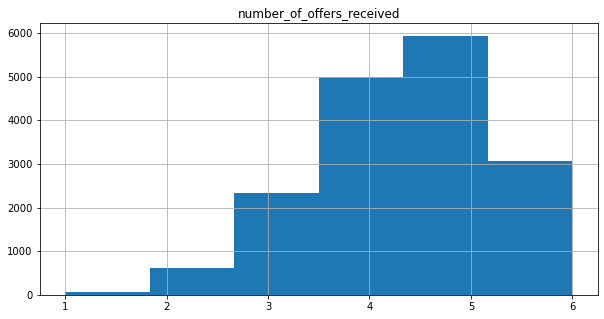

In [160]:
transcript['number_of_offers_received'] = 1
transcript.loc[transcript['event'] == 'offer received'].groupby('person').sum().hist('number_of_offers_received', bins = 6, figsize = [10,5])
transcript.drop(columns = ['number_of_offers_received'], inplace = True)

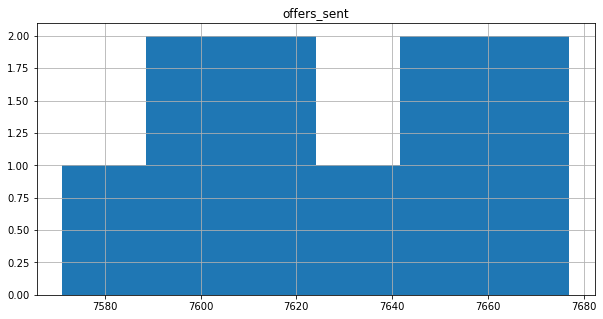

In [161]:
transcript['offers_sent'] = 1
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if x.get('offer id') else 'NaN')
transcript.loc[transcript['event'] == 'offer received'].groupby('offer_id').sum().hist('offers_sent', bins = 6, figsize = [10,5])
transcript.drop(columns = ['offer_id', 'offers_sent'], inplace = True)

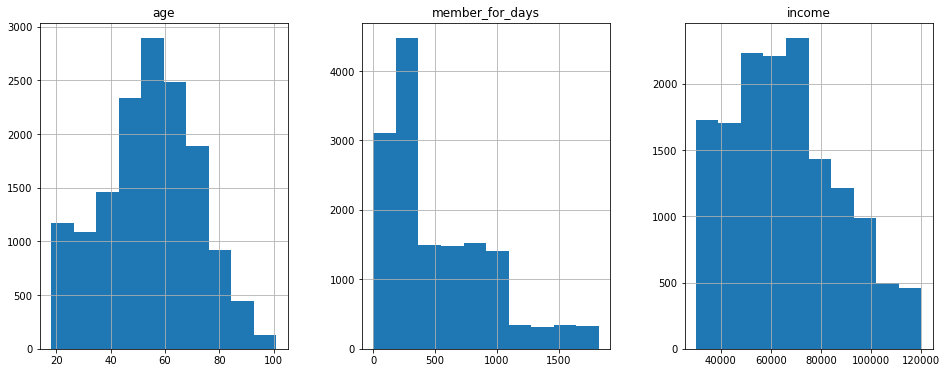

In [162]:
hist = profile.hist(figsize = (16,6), layout = (1,3))

In [163]:
def one_hot_encode(df, column_name):
    value = df[column_name].values[0]
    if hasattr(value, "__iter__") and type(value) is not str:
        all_values = df[column_name].apply(lambda x: tuple(x)).unique()
        unique_values = set([])
        for i in all_values:
            for j in i:
                unique_values.add(j)
        for i in unique_values:
            df[i] = df[column_name].apply(lambda x:1 if i in x else 0)
    else:
        unique_values = df[column_name].unique()
        for i in unique_values:
            df[i] = df[column_name].apply(lambda x:1 if x==i else 0)
            
    df.drop(columns = [column_name], inplace = True)

In [164]:
one_hot_encode(portfolio, 'channels')
one_hot_encode(portfolio, 'offer_type')
one_hot_encode(profile, 'gender')

In [165]:
def calculate_responses_and_spending(transcript, portfolio):
    columns = ['offer_id', 'customer_id', 'viewed', 'completed']
    
    #get data about informational offers because special rules apply to them. They don't have a 'offer completed' event
    #so they will be considered completed after the person sees the offer and makes a purchase
    info_df = portfolio.loc[portfolio['informational'] == 1]
    info_ids = info_df['offer_id'].values
    info_duration = info_df['duration_hours'].values
    
    #initializing variables we will need
    response_dict = {} #here we keep number of viewed, completed and received offers for each person
    offer_dict = {} #here we keep whether someone viewed or completed for every offer that was sent
    list = [] #offer_dict will be loaded here, dict was used because of fast lookup time
    spent_dict = {} #amount of money spent for each customer
    
    #looping through the dataframe and processessing the data in a way that we need to loop only once
    for log in transcript.values:    
        person_id = log[1]
        if log[0] == 'offer received':
            offer_id = log[3]['offer id']
            offer_dict[f'{offer_id}_{person_id}'] = [0, 0]
            for i in range(len(info_ids)):
                if offer_id == info_ids[i]:
                    hour_end = info_duration[i] + log[2] 
                    offer_dict[f'{offer_id}_{person_id}'].extend([hour_end+1, hour_end])
            try:
                response_dict[person_id][2] += 1
            except KeyError:
                response_dict[person_id] = [0, 0, 1]
        elif log[0] == 'offer viewed':
            offer_id = log[3]['offer id']
            offer_dict[f'{offer_id}_{person_id}'][0] = 1
            for i in range(len(info_ids)):
                if offer_id == info_ids[i]:
                    offer_dict[f'{offer_id}_{person_id}'][2] = log[2]
            response_dict[person_id][0] += 1
        elif log[0] == 'offer completed':
            offer_id = log[3]['offer_id']
            offer_dict[f'{offer_id}_{person_id}'][1] = 1
            response_dict[person_id][1] += 1
        elif log[0] == 'transaction':
            amount = log[3]['amount']
            try:
                spent_dict[person_id] += amount
            except KeyError:
                spent_dict[person_id] = amount
            for i in info_ids:
                temp_list = offer_dict.get(f'{i}_{person_id}')
                if temp_list and log[2] >= temp_list[2] and log[2] <= temp_list[3]:
                    if temp_list[1] == 0:
                        response_dict[person_id][1] += 1
                    temp_list[1] = 1
                    
        else:
            print(log[0])
            raise Exception('Unknown event')
        
    for k,v in offer_dict.items():

        und_index = k.index('_')
        offer_id = k[:und_index]
        person_id = k[und_index+1:]
        list.append([offer_id, person_id, v[0], v[1]])
    
    #make the resulting dataframe from list
    offer_responses = pd.DataFrame(columns = columns, index = range(len(list)), data = list)
    
    #add extra columns from the dicts
    offer_responses['total_amount'] = offer_responses['customer_id'].apply(lambda x: spent_dict.get(x) if spent_dict.get(x) else 0)
    offer_responses['viewed_rate'] = offer_responses['customer_id'].apply(lambda x: response_dict.get(x)[0]/response_dict.get(x)[2] if response_dict.get(x) else 0)
    offer_responses['completed_rate'] = offer_responses['customer_id'].apply(lambda x: response_dict.get(x)[1]/response_dict.get(x)[2] if response_dict.get(x) else 0)
    return offer_responses

In [166]:
#calculate the response rate per person
def response_rate(df):
    response_dict = {}
    for log in df[['customer_id', 'responded']].values:
        cus_id = log[0]
        response = log[1]
        try:
            response_dict[cus_id][0] += response
        except:
            response_dict[cus_id] = [response, 0]
        response_dict[cus_id][1] += 1
        
    df['response_rate'] = df['customer_id'].apply(lambda x: float(response_dict[x][0]) / response_dict[x][1])
    return df

In [95]:
response_df = calculate_responses_and_spending(transcript, portfolio)
response_df['responded'] = response_df.apply(lambda x: int(x['completed'] == 1 and x['viewed'] == 1), axis = 1)
response_df = response_rate(response_df)

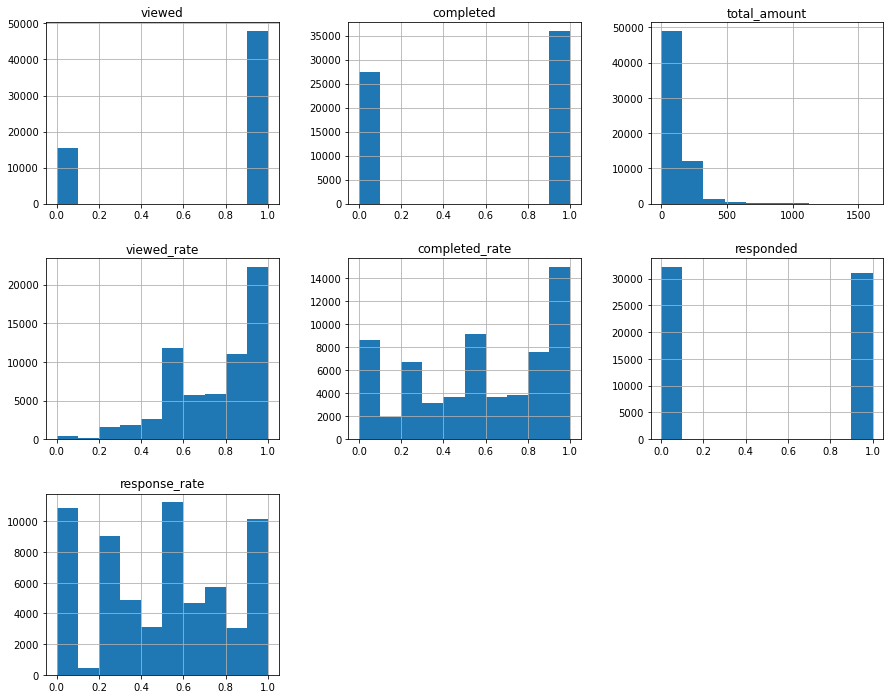

In [96]:
_ = response_df.hist(figsize = (15, 12))


In [97]:
response_df.describe()

,viewed,completed,total_amount,viewed_rate,completed_rate,responded,response_rate
count,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,0.756320,0.567643,106.434725,0.758087,0.564865,0.490772,0.490772
std,0.429305,0.495407,127.616131,0.229101,0.346666,0.499919,0.330888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,22.280000,0.600000,0.250000,0.000000,0.250000
50%,1.000000,1.000000,70.780000,0.800000,0.600000,0.000000,0.500000
75%,1.000000,1.000000,151.670000,1.000000,0.833333,1.000000,0.750000
max,1.000000,1.000000,1608.690000,1.000000,1.000000,1.000000,1.000000


In [98]:
merged_df = profile.merge(response_df, on = ['customer_id']).merge(portfolio, on = ['offer_id'])
merged_df.head()

,age,customer_id,member_for_days,income,F,M,O,offer_id,viewed,completed,...,reward,difficulty,duration_hours,social,web,email,mobile,bogo,informational,discount
0,55,0610b486422d4921ae7d2bf64640c50b,376,112000.0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,...,5,5,4032,0,1,1,1,1,0,0
1,75,78afa995795e4d85b5d9ceeca43f5fef,443,100000.0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,5,5,4032,0,1,1,1,1,0,0
2,68,e2127556f4f64592b11af22de27a7932,91,70000.0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,5,5,4032,0,1,1,1,1,0,0
3,65,389bc3fa690240e798340f5a15918d5c,167,53000.0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,5,5,4032,0,1,1,1,1,0,0
4,57,6445de3b47274c759400cd68131d91b4,207,42000.0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,...,5,5,4032,0,1,1,1,1,0,0


In [99]:
def scale_column(df, column_name):
    scaler = MinMaxScaler()
    df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1, 1))

#scale required columns
scale_column(merged_df, 'income')
scale_column(merged_df, 'age')
scale_column(merged_df, 'difficulty')
scale_column(merged_df, 'reward')
scale_column(merged_df, 'total_amount')
scale_column(merged_df, 'duration_hours')

In [100]:
merged_df.groupby(['offer_id'])[['responded', 'bogo', 'informational', 'discount']].mean().sort_values(by = 'responded')

,responded,bogo,informational,discount
offer_id,,,,
0b1e1539f2cc45b7b9fa7c272da2e1d7,0.230315,0.0,0.0,1.0
2906b810c7d4411798c6938adc9daaa5,0.388869,0.0,0.0,1.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,0.393540,1.0,0.0,0.0
3f207df678b143eea3cee63160fa8bed,0.454743,0.0,1.0,0.0
ae264e3637204a6fb9bb56bc8210ddfd,0.479871,1.0,0.0,0.0
4d5c57ea9a6940dd891ad53e9dbe8da0,0.488659,1.0,0.0,0.0
f19421c1d4aa40978ebb69ca19b0e20d,0.610652,1.0,0.0,0.0
2298d6c36e964ae4a3e7e9706d1fb8c2,0.713637,0.0,0.0,1.0
fafdcd668e3743c1bb461111dcafc2a4,0.728716,0.0,0.0,1.0


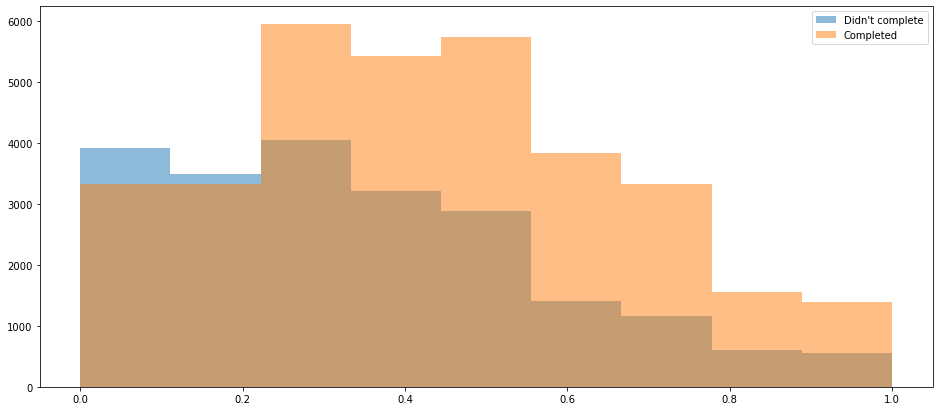

In [101]:
plt.figure(figsize = [16,7])
test_amount_values = merged_df.loc[merged_df['completed'] == 0]['income'].values 
test_2_values = merged_df.loc[merged_df['completed'] == 1]['income'].values
test_hist = plt.hist(test_amount_values, bins = np.linspace(0, 1,10), alpha = 0.5, label = "Didn't complete")
test_2hist = plt.hist(test_2_values, bins = np.linspace(0, 1,10), alpha = 0.5, label = 'Completed')
plt.legend()

In [102]:
merged_df.drop(columns = ['customer_id', 'offer_id', 'viewed', 'completed'], inplace = True)

In [103]:
cols = merged_df.columns.tolist()
label_idx = cols.index('responded')
cols = cols[label_idx:label_idx+1] + cols[:label_idx] + cols[label_idx+1:]
merged_df = merged_df[cols]

In [104]:
merged_df.head()

,responded,age,member_for_days,income,F,M,O,total_amount,viewed_rate,completed_rate,...,reward,difficulty,duration_hours,social,web,email,mobile,bogo,informational,discount
0,0,0.445783,376,0.911111,1,0,0,0.047871,0.00,0.500000,...,0.5,0.25,0.571429,0,1,1,1,1,0,0
1,1,0.686747,443,0.777778,1,0,0,0.099006,1.00,1.000000,...,0.5,0.25,0.571429,0,1,1,1,1,0,0
2,1,0.602410,91,0.444444,0,1,0,0.035886,0.75,0.500000,...,0.5,0.25,0.571429,0,1,1,1,1,0,0
3,1,0.566265,167,0.255556,0,1,0,0.022646,1.00,0.833333,...,0.5,0.25,0.571429,0,1,1,1,1,0,0
4,0,0.469880,207,0.133333,0,1,0,0.011873,0.20,0.400000,...,0.5,0.25,0.571429,0,1,1,1,1,0,0


In [105]:
X = merged_df.values[:, 1:]
y = merged_df.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

# model training

In [108]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir

     |████████████████████████████████| 952 kB 27.4 MB/s            
  Attempting uninstall: wheel
    Found existing installation: wheel 0.36.2
    Uninstalling wheel-0.36.2:
      Successfully uninstalled wheel-0.36.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.6.0.post20210108
    Uninstalling setuptools-49.6.0.post20210108:
      Successfully uninstalled setuptools-49.6.0.post20210108
     |████████████████████████████████| 47.3 MB 66 kB/s              
     |████████████████████████████████| 8.6 MB 57.4 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080040 sha256=15680a7ce0d9281e8c402b31d8b7b8844031130e78765e9419c0d01b917efb98
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e3/99/1c/1773fc73b6df1708ded8d1c713726edc8c93714115ef849fd8
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.19.1
    Uninstalling 

In [121]:
train= pd.DataFrame(X_train)
train.insert(0, 'label', y_train)
test=pd.DataFrame(X_test)

In [123]:
#Autogloun
import pandas as pd
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label='label', eval_metric = 'root_mean_squared_error').fit(train_data=train, time_limit=600, presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220127_210800/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220127_210800/"
AutoGluon Version:  0.3.1
Train Data Rows:    36998
Train Data Columns: 20
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0.0, 1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2715.26 MB
	Train Data (Original)  Memory Usage: 5.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Se

[21:09:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:09:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

	-0.3677	 = Validation score   (root_mean_squared_error)
	7.51s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1 ... Training model for up to 302.21s of the 502.24s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 7)
	Ran out of time, stopping training early. (Stopping on epoch 10)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 13)
	Ran out of time, stopping training early. (Stopping on epoch 14)
	Ran out of time, stopping training early. (Stopping on epoch 16)
	Ran out of time, stopping training early. (Stopping on epoch 20)
	-0.366	 = Validation score   (root_mean_squared_error)
	287.9s	 = Training   runtime
	3.17s	 = Validation runtime
Fit

[21:16:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:16:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:16:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:16:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

	-0.3573	 = Validation score   (root_mean_squared_error)
	8.19s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L2 ... Training model for up to 89.32s of the 89.3s of remaining time.
	Ran out of time, stopping training early. (Stopping on epoch 1)
	Ran out of time, stopping training early. (Stopping on epoch 1)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 2)
	Ran out of time, stopping training early. (Stopping on epoch 3)
	Ran out of time, stopping training early. (Stopping on epoch 3)
	Ran out of time, stopping training early. (Stopping on epoch 5)
	-0.3601	 = Validation score   (root_mean_squared_error)
	82.64s	 = Training   runtime
	4.15s	 = Validation runtime
Fitting model:

In [124]:
predictions = predictor.predict(test)

In [125]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3  -0.356911      10.647235  413.111580                0.068361           9.863471            3       True         21
1         LightGBMXT_BAG_L2  -0.356986      10.491283  389.850707                0.171189          19.411113            2       True         13
2           LightGBM_BAG_L2  -0.357176      10.407686  383.836996                0.087591          13.397401            2       True         14
3            XGBoost_BAG_L2  -0.357289      10.454600  378.626731                0.134506           8.187136            2       True         19
4   RandomForestEntr_BAG_L2  -0.359213      11.886208  391.975338                1.566114          21.535743            2       True         16
5     ExtraTreesEntr_BAG_L2  -0.359439      12.090562  375.451194         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetMXNet_BAG_L1': 'StackerEnsembleModel_TabularNeuralNet',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L2': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesGini_BAG_L2': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L2': 'StackerEnsembleModel_XT',
  'XGBoost_

In [126]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [127]:
accuracy_score(y_test, y_pred)

0.8184811237928007

In [128]:
cat_model = CatBoostClassifier(iterations = 350, learning_rate = 0.126)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_acc = accuracy_score(y_test, cat_pred)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.5627871	total: 7.76ms	remaining: 2.71s
1:	learn: 0.4950259	total: 15ms	remaining: 2.61s
2:	learn: 0.4587471	total: 21.7ms	remaining: 2.51s
3:	learn: 0.4316365	total: 28.5ms	remaining: 2.47s
4:	learn: 0.4037611	total: 35.3ms	remaining: 2.44s
5:	learn: 0.3886668	total: 42.2ms	remaining: 2.42s
6:	learn: 0.3768831	total: 48.3ms	remaining: 2.36s
7:	learn: 0.3646903	total: 55.1ms	remaining: 2.35s
8:	learn: 0.3517585	total: 61.8ms	remaining: 2.34s
9:	learn: 0.3448928	total: 68.8ms	remaining: 2.34s
10:	learn: 0.3367538	total: 76.1ms	remaining: 2.35s
11:	learn: 0.3324929	total: 83.1ms	remaining: 2.34s
12:	learn: 0.3293752	total: 90ms	remaining: 2.33s
13:	learn: 0.3247420	total: 97.1ms	remaining: 2.33s
14:	learn: 0.3225610	total: 104ms	remaining: 2.33s
15:	learn: 0.3183789	total: 111ms	remaining: 2.31s
16:	learn: 0.3145530	total: 118ms	remaining: 2.31s
17:	learn: 0.3124294	total: 125ms	remaining: 2.3s
18:	learn: 0.3110326	total: 131ms	remaining: 2.28s
19:	learn: 0.3087080	total: 138m

In [129]:
cat_acc

0.8642998244073749